<a href="https://colab.research.google.com/github/klausgottlieb/crut-monte-carlo-replication/blob/main/notebook_04_payout_7520.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 04 — Payout Rate and §7520 Rate
## *When Do Charitable Remainder Unitrusts Outperform? A Monte Carlo Analysis*
### Klaus Gottlieb, JD, MS, MBA — Wealth Care Lawyer, Cayucos, CA

---

## Purpose

This notebook examines two parameters that govern the CRUT's internal economics at inception:

### The Payout Rate

The payout rate is the single most consequential *design choice* available to the practitioner drafting the trust instrument. Unlike expected return or longevity — which are uncertain at inception — the payout rate is selected deliberately and fixed irrevocably in the trust document. Getting it right matters.

The payout rate is unusual among CRUT parameters because it has **two simultaneous and opposing effects on the deduction:**

1. **Higher payout → more distributions** — more income to beneficiaries, which is the primary purpose of the trust. This directly increases the economic value of the CRUT to the donor.

2. **Higher payout → smaller charitable deduction** — as the payout rate rises, the IRS remainder factor R falls (because more is expected to go to beneficiaries, less to charity). At a payout rate of approximately 8–9%, the 10% remainder test (IRC §664(d)(2)(D)) becomes binding and caps the payout rate entirely for most age combinations.

The result is a **non-monotonic relationship** between payout rate and win probability. There is an optimal payout rate that maximizes CRUT attractiveness — and it is not necessarily the highest rate the IRS permits.

The IRS imposes a **minimum payout rate of 5%** (IRC §664(d)(2)(A)) and a maximum determined by the 10% remainder test. For Two Life 63/65 at a 5% §7520 rate, the maximum payout rate that passes the 10% test is approximately **7.9%**. This notebook identifies the win-probability-maximizing rate within that range.

### The §7520 Rate

The §7520 rate (also called the AFR hurdle rate or the IRS discount rate for charitable transfers) ranked **#12 of 12 parameters** in the OAT sensitivity analysis — dead last, with essentially zero impact on win probability across its full historical range (1.2% to 8.2%).

This is counterintuitive. The §7520 rate governs the size of the charitable deduction — a higher rate means a larger deduction (the remainder is discounted more heavily, making the charity's future interest worth less, which means the donor's deduction is larger). One would expect this to matter for win probability.

**The reason it does not:** The §7520 rate affects both the charitable deduction *and* the discount rate used to present-value the CRUT's future distributions. These two effects nearly exactly offset each other across the realistic range of §7520 rates. A higher §7520 rate gives a larger deduction (good for CRUT) but also discounts future distributions more heavily (bad for CRUT). The net effect on win probability is approximately zero.

This finding has a practical implication: **practitioners do not need to time CRUT formation around the §7520 rate.** The common belief that a high §7520 rate is unambiguously better for CRUTs is not supported by this analysis. This notebook provides a full decomposition of why.

---

## OAT Results from Notebook 01 (Reference)

| Parameter | OAT rank | Win prob range | Range (pp) |
|---|---|---|---|
| Expected return μ | #1 | varies | ~55 |
| Longevity adj | #2 | varies | ~39 |
| Benchmark fee | #3 | varies | ~31 |
| Asset basis | #5 | varies | ~27 |
| **Payout rate** | **#4** | **varies** | **~29** |
| **§7520 rate** | **#12** | **~flat** | **~0** |

The payout rate ranks #4 and the §7520 rate ranks #12. Their contrasting rankings motivate the detailed decomposition in this notebook.

---

## Sections and Figures

1. **Payout rate sweep** — win probability vs. payout rate (5%–8%) across four turnover levels. Highlights the non-monotonic shape and the 10% test constraint.
2. **Payout rate deduction decomposition** — shows deduction, PV tax benefit, and distribution stream PV separately as functions of payout rate.
3. **Payout rate × basis interaction heatmap** — does the optimal payout rate depend on asset basis?
4. **Payout rate × age interaction** — does the optimal payout rate depend on donor age?
5. **§7520 rate sweep and decomposition** — why the rate ranks last despite affecting deduction size.
6. **§7520 rate × payout rate joint analysis** — the combined planning surface.

---

In [1]:
import subprocess, sys
subprocess.check_call([sys.executable, '-m', 'pip', 'install',
                       'numpy', 'matplotlib', 'scipy', '--quiet'])
print('Dependencies confirmed.')

Dependencies confirmed.


In [2]:
from dataclasses import dataclass, replace
from typing import Optional
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

plt.rcParams.update({
    'figure.dpi': 120,
    'font.family': 'sans-serif',
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'figure.facecolor': 'white',
})

TURNOVER_LEVELS = [0.00, 0.20, 0.40, 0.60]
TURNOVER_LABELS = ['0% (buy-and-hold)', '20% (moderate)', '40% (active)', '60% (original baseline)']
TURNOVER_COLORS = ['#08306b', '#2171b5', '#fd8d3c', '#d73027']

print('Imports complete.')

Imports complete.


In [3]:
# =============================================================================
# COMPLETE SIMULATION ENGINE (self-contained)
# =============================================================================

IRS_LIFE_EXPECTANCY = {
    35: 48.3, 40: 43.6, 45: 38.9, 50: 34.2, 55: 29.6,
    60: 25.2, 61: 24.4, 62: 23.5, 63: 22.7, 64: 21.8,
    65: 21.0, 66: 20.2, 67: 19.4, 68: 18.6, 69: 17.8,
    70: 17.0, 71: 16.3, 72: 15.5, 73: 14.8, 74: 14.1,
    75: 13.4, 76: 12.7, 77: 12.1, 78: 11.4, 79: 10.8,
    80: 10.2, 85: 7.3,  90: 5.0
}

def get_life_expectancy(age):
    if age in IRS_LIFE_EXPECTANCY:
        return IRS_LIFE_EXPECTANCY[age]
    ages = sorted(IRS_LIFE_EXPECTANCY.keys())
    for i in range(len(ages) - 1):
        if ages[i] < age < ages[i+1]:
            a1, a2 = ages[i], ages[i+1]
            return (IRS_LIFE_EXPECTANCY[a1]
                    + (IRS_LIFE_EXPECTANCY[a2] - IRS_LIFE_EXPECTANCY[a1])
                    * (age - a1) / (a2 - a1))
    raise ValueError(f'Age {age} out of range')

def get_joint_life_expectancy(age1, age2):
    e1, e2 = get_life_expectancy(age1), get_life_expectancy(age2)
    return e1 + e2 - 1.0 / (1.0/e1 + 1.0/e2)

def compute_deduction(fmv, payout_rate, rate_7520, life_type,
                      age1=65, age2=None, term_years=20,
                      freq=4, lag_months=0, longevity_adj=0):
    """
    Compute CRUT charitable deduction using IRS Reg. 1.664-4 method.
    Table F adjustment: rate_7520 / (freq * ((1+rate_7520)^(1/freq) - 1))
    For 5% rate quarterly: table_f ~ 1.0186, adjusted payout ~ 6.11%.
    R must be >= 10% (IRC 664 charitable remainder requirement).

    IMPORTANT — §7520 rate dual role:
    The §7520 rate appears in two places in the economics:
      (1) In this function: determines the Table F adjustment factor and
          therefore the remainder factor R and deduction size.
          Higher §7520 rate → larger Table F → smaller adjusted payout
          → higher R → larger deduction.
      (2) In run_simulation: used as the discount rate (pv_rate) for
          present-valuing future distributions and the benchmark terminal value.
          Higher pv_rate → distributions discounted more heavily → lower
          PV of CRUT wealth.
    These two effects nearly cancel, explaining the §7520 rate's rank of
    #12 in the OAT sensitivity analysis. See Section 5 for full decomposition.
    """
    i, p = rate_7520, payout_rate
    table_f         = i / (freq * ((1 + i) ** (1/freq) - 1))
    adjusted_payout = p * table_f
    if life_type == 'Term of Years':
        irs_duration = float(term_years)
    elif life_type == 'Single Life':
        irs_duration = get_life_expectancy(age1)
    else:
        irs_duration = get_joint_life_expectancy(age1, age2)
    R = max(0.0, min(1.0, (1 - adjusted_payout) ** irs_duration))
    return {
        'deduction':        fmv * R,
        'remainder_factor': R,
        'compliance':       R >= 0.10,
        'irs_duration':     irs_duration,
        'sim_horizon':      irs_duration + longevity_adj,
        'table_f':          table_f,
        'adjusted_payout':  adjusted_payout,
    }

def generate_return_paths(mu, sigma, n_years, n_paths, seed=None):
    if seed is not None:
        np.random.seed(seed)
    mu_log    = np.log(1 + mu) - 0.5 * (sigma / (1 + mu)) ** 2
    sigma_log = sigma / (1 + mu)
    return np.exp(np.random.normal(mu_log, sigma_log, size=(n_paths, n_years)))

@dataclass
class ScenarioParams:
    fmv:                float        = 1_000_000
    basis_pct:          float        = 0.20
    agi:                float        = 500_000
    payout_rate:        float        = 0.06
    life_type:          str          = 'Two Life'
    age1:               int          = 63
    age2:               Optional[int]= 65
    term_years:         int          = 20
    freq:               int          = 4
    lag_months:         int          = 0
    longevity_adj:      int          = 0
    rate_7520:          float        = 0.05
    pv_rate:            float        = 0.05
    fed_ordinary:       float        = 0.37
    fed_ltcg:           float        = 0.20
    niit:               float        = 0.038
    state_rate:         float        = 0.093
    agi_limit_pct:      float        = 0.30
    carryforward_years: int          = 5
    trust_fee:          float        = 0.01
    bench_fee:          float        = 0.01
    turnover:           float        = 0.20
    mu:                 float        = 0.07
    sigma:              float        = 0.12
    n_paths:            int          = 2000
    seed:               int          = 42

def run_simulation(params, return_components=False):
    """
    Run paired-path Monte Carlo CRUT vs. hold-liquidation benchmark.

    If return_components=True, also return the PV of distributions and
    PV of tax benefit separately (for the §7520 decomposition in Section 5).

    Note on pv_rate: In the baseline, pv_rate = rate_7520 = 5%. This
    reflects the convention that the §7520 rate serves as both the IRS
    actuarial discount rate and a reasonable risk-free discount rate for
    present-valuing trust distributions. In Section 5, we separately vary
    rate_7520 (which affects the deduction) while holding pv_rate constant
    to isolate the deduction effect, then vary both together to show the
    full offset mechanism.
    """
    p       = params
    tau_ord = p.fed_ordinary + p.state_rate
    tau_cg  = p.fed_ltcg + p.niit + p.state_rate

    ded_res = compute_deduction(
        fmv=p.fmv, payout_rate=p.payout_rate, rate_7520=p.rate_7520,
        life_type=p.life_type, age1=p.age1, age2=p.age2,
        term_years=p.term_years, freq=p.freq, lag_months=p.lag_months,
        longevity_adj=p.longevity_adj,
    )
    T           = max(1, int(round(ded_res['sim_horizon'])))
    deduction   = ded_res['deduction']
    annual_limit= p.agi * p.agi_limit_pct
    remaining   = deduction
    pv_tax      = 0.0
    for yr in range(p.carryforward_years + 1):
        usable    = min(remaining, annual_limit)
        if usable <= 0: break
        pv_tax   += usable * tau_ord / (1 + p.pv_rate) ** yr
        remaining -= usable

    returns = generate_return_paths(p.mu, p.sigma, T, p.n_paths, seed=p.seed)

    # CRUT
    crut_v = np.full(p.n_paths, p.fmv)
    dists  = np.zeros((p.n_paths, T))
    for t in range(T):
        v          = crut_v * (1 - p.trust_fee) * returns[:, t]
        d          = v * p.payout_rate
        dists[:, t]= d * (1 - tau_ord)
        crut_v     = np.maximum(0, v - d)
    disc        = np.array([(1 + p.pv_rate) ** -(t+1) for t in range(T)])
    pv_dists    = (dists * disc).sum(axis=1)
    crut_wealth = pv_dists + pv_tax

    # Benchmark (hold-liquidation)
    bench_v    = np.full(p.n_paths, p.fmv)
    bench_basis= p.fmv * p.basis_pct
    for t in range(T):
        b          = bench_v * (1 - p.bench_fee) * returns[:, t]
        gain       = np.maximum(0, b - bench_basis)
        tax_drag   = p.turnover * gain * tau_cg
        bench_v    = np.maximum(0, b - tax_drag)
        bench_basis= bench_basis + p.turnover * gain * (1 - tau_cg)
    term_gain    = np.maximum(0, bench_v - bench_basis)
    bench_term   = bench_v - term_gain * tau_cg
    bench_wealth = bench_term / (1 + p.pv_rate) ** T

    delta = crut_wealth - bench_wealth
    out = {
        'win_prob':       float(np.mean(delta > 0)),
        'median_delta':   float(np.median(delta)),
        'delta_wealth':   delta,
        'pv_tax':         pv_tax,
        'deduction':      deduction,
        'remainder_factor': ded_res['remainder_factor'],
        'compliance':     ded_res['compliance'],
        'T':              T,
        'params':         p,
    }
    if return_components:
        out['pv_dists']       = float(np.mean(pv_dists))
        out['mean_crut']      = float(np.mean(crut_wealth))
        out['mean_bench']     = float(np.mean(bench_wealth))
        out['table_f']        = ded_res['table_f']
        out['adjusted_payout']= ded_res['adjusted_payout']
    return out

# Verify baseline
baseline = ScenarioParams()
r0 = run_simulation(baseline, return_components=True)
print('Baseline verification (Two Life 63/65, 6% payout, 5% §7520, 20% turnover):')
print(f'  Win probability:   {r0["win_prob"]:.1%}')
print(f'  Median delta:      ${r0["median_delta"]:,.0f}')
print(f'  Deduction:         ${r0["deduction"]:,.0f}')
print(f'  Remainder factor:  {r0["remainder_factor"]:.4f}')
print(f'  10% test:          {r0["compliance"]}')
print(f'  PV tax benefit:    ${r0["pv_tax"]:,.0f}')
print(f'  Mean PV dists:     ${r0["pv_dists"]:,.0f}')
print(f'  Sim horizon:       {r0["T"]} yr')
print()

# Show 10% test constraint for this age/rate combination
print('10% test feasibility across payout rates (Two Life 63/65, 5% §7520):')
for pr in [0.05, 0.06, 0.07, 0.075, 0.079, 0.08, 0.085]:
    d = compute_deduction(1_000_000, pr, 0.05, 'Two Life', 63, 65)
    status = 'PASS' if d['compliance'] else 'FAIL'
    print(f'  {pr*100:.1f}%  R={d["remainder_factor"]:.4f}  '
          f'deduction=${d["deduction"]:>10,.0f}  10%% test: {status}')
print()
print('Engine ready.')

Baseline verification (Two Life 63/65, 6% payout, 5% §7520, 20% turnover):
  Win probability:   54.3%
  Median delta:      $19,397
  Deduction:         $126,456
  Remainder factor:  0.1265
  10% test:          True
  PV tax benefit:    $58,549
  Mean PV dists:     $520,913
  Sim horizon:       33 yr

10% test feasibility across payout rates (Two Life 63/65, 5% §7520):
  5.0%  R=0.1801  deduction=$   180,138  10%% test: PASS
  6.0%  R=0.1265  deduction=$   126,456  10%% test: PASS
  7.0%  R=0.0884  deduction=$    88,430  10%% test: FAIL
  7.5%  R=0.0738  deduction=$    73,840  10%% test: FAIL
  7.9%  R=0.0639  deduction=$    63,875  10%% test: FAIL
  8.0%  R=0.0616  deduction=$    61,595  10%% test: FAIL
  8.5%  R=0.0513  deduction=$    51,329  10%% test: FAIL

Engine ready.


---
## Section 1 — Payout Rate Sweep

### Figure 1: Win Probability vs. Payout Rate

The payout rate sweep runs from the IRS minimum of **5%** to approximately **8%**, which is near the maximum that passes the 10% remainder test for Two Life 63/65 at a 5% §7520 rate. Rates above the 10% test threshold are shown as a shaded region to indicate they are not permissible at these ages.

**Expected shape of the curves:**

- At low payout rates (near 5%), the deduction is large (high remainder factor) but distributions are modest. The total CRUT value is dominated by deduction benefit.
- As payout rate rises, distributions increase — but so does the adjusted payout factor, which compresses the remainder factor and shrinks the deduction. The two effects are approximately offsetting at intermediate rates.
- Near the 10% test ceiling, the deduction approaches zero. Win probability becomes entirely dependent on the distribution stream, which peaks here — but without the deduction benefit, the CRUT may not outperform.

This produces a curve with an interior maximum. The location of that maximum is the **win-probability-optimizing payout rate** — the answer to the question: "What payout rate should I put in this trust document?"

Note that the win-probability-maximizing rate may differ from the rate that maximizes expected distributions or the rate that maximizes PV of total wealth. Section 2 decomposes these components separately.

Running payout rate sweep...
  0% turnover: done
  20% turnover: done
  40% turnover: done
  60% turnover: done


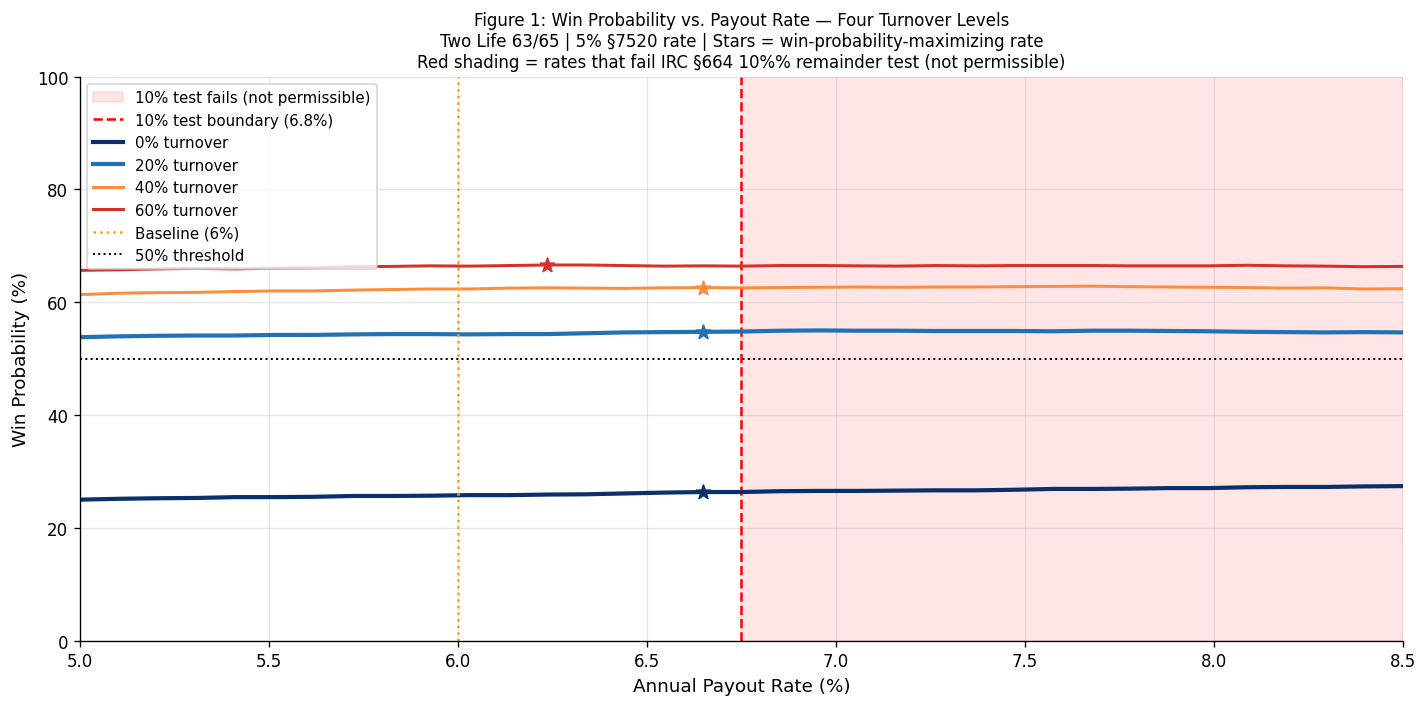

Figure 1 saved.

Optimal (win-prob-maximizing) payout rate by turnover:
  0% (buy-and-hold): 6.6%  (win prob = 26.4%)
  20% (moderate): 6.6%  (win prob = 54.8%)
  40% (active): 6.6%  (win prob = 62.6%)
  60% (original baseline): 6.2%  (win prob = 66.6%)


In [4]:
# --- Figure 1: Win probability vs. payout rate ---

payout_rates = np.linspace(0.050, 0.085, 35)

# Find 10% test boundary for this age/rate combination
test_boundary = None
for pr in payout_rates:
    d = compute_deduction(1_000_000, pr, baseline.rate_7520, 'Two Life',
                          baseline.age1, baseline.age2)
    if not d['compliance']:
        test_boundary = pr
        break

print('Running payout rate sweep...')
payout_results = {}  # turnover -> {'wp': array, 'compliance': array}
for tv in TURNOVER_LEVELS:
    wp_arr, comp_arr = [], []
    for pr in payout_rates:
        r = run_simulation(replace(baseline, payout_rate=pr, turnover=tv))
        wp_arr.append(r['win_prob'])
        comp_arr.append(r['compliance'])
    payout_results[tv] = {
        'wp':         np.array(wp_arr),
        'compliance': np.array(comp_arr),
    }
    print(f'  {tv*100:.0f}% turnover: done')

fig, ax = plt.subplots(figsize=(12, 6))

# Shade the region that fails the 10% test
if test_boundary is not None:
    ax.axvspan(test_boundary * 100, payout_rates[-1] * 100,
               alpha=0.10, color='red', label='10% test fails (not permissible)')
    ax.axvline(test_boundary * 100, color='red', lw=1.5, ls='--',
               label=f'10% test boundary ({test_boundary*100:.1f}%)')

for tv, color, tv_label, lw in zip(
        TURNOVER_LEVELS, TURNOVER_COLORS, TURNOVER_LABELS, [2.5,2.5,1.8,1.8]):
    wp = payout_results[tv]['wp']
    ax.plot(payout_rates * 100, wp * 100, color=color, lw=lw,
            label=f'{tv*100:.0f}% turnover')
    # Mark the optimal payout rate
    comp_mask = payout_results[tv]['compliance']
    valid_wp  = np.where(comp_mask, wp, -np.inf)
    opt_idx   = np.argmax(valid_wp)
    ax.scatter(payout_rates[opt_idx]*100, wp[opt_idx]*100,
               color=color, s=80, zorder=5, marker='*')

ax.axvline(6.0, color='orange', lw=1.5, ls=':', label='Baseline (6%)')
ax.axhline(50,  color='black',  lw=1.2, ls=':', label='50% threshold')

ax.set_xlabel('Annual Payout Rate (%)', fontsize=11)
ax.set_ylabel('Win Probability (%)', fontsize=11)
ax.set_xlim(payout_rates[0]*100, payout_rates[-1]*100)
ax.set_ylim(0, 100)
ax.set_title(
    'Figure 1: Win Probability vs. Payout Rate — Four Turnover Levels\n'
    'Two Life 63/65 | 5% §7520 rate | Stars = win-probability-maximizing rate\n'
    'Red shading = rates that fail IRC §664 10%% remainder test (not permissible)',
    fontsize=10
)
ax.legend(fontsize=9)
plt.tight_layout()
plt.savefig('fig1_payout_sweep.png', bbox_inches='tight', dpi=150)
plt.show()

print('Figure 1 saved.')
print()
print('Optimal (win-prob-maximizing) payout rate by turnover:')
for tv, tv_label in zip(TURNOVER_LEVELS, TURNOVER_LABELS):
    wp   = payout_results[tv]['wp']
    comp = payout_results[tv]['compliance']
    valid_wp = np.where(comp, wp, -np.inf)
    opt_idx  = np.argmax(valid_wp)
    print(f'  {tv_label}: {payout_rates[opt_idx]*100:.1f}%  '
          f'(win prob = {wp[opt_idx]:.1%})')

---
## Section 2 — Payout Rate Decomposition

### Figure 2: Component Decomposition — Deduction vs. Distribution Stream

Win probability is the primary output, but understanding *why* it has an interior maximum requires looking at the components separately. This figure shows how the three components of CRUT economic value change as a function of payout rate:

1. **PV of tax benefit from charitable deduction** — decreasing in payout rate (higher payout compresses the deduction).
2. **Mean PV of after-tax distributions** — increasing then flat in payout rate (more distributions, but each dollar of distribution is worth less as the trust corpus depletes faster).
3. **Total CRUT value** — the sum, which has an interior maximum.

The figure also shows the **remainder factor R** on a secondary axis, directly illustrating how the IRS formula links payout rate to the deduction constraint.

This decomposition is important for the manuscript because it explains the non-intuitive finding that increasing the payout rate does not monotonically increase CRUT attractiveness. Practitioners who routinely set payout rates at the IRS maximum (to maximize client income) may be inadvertently reducing the CRUT's competitive advantage.

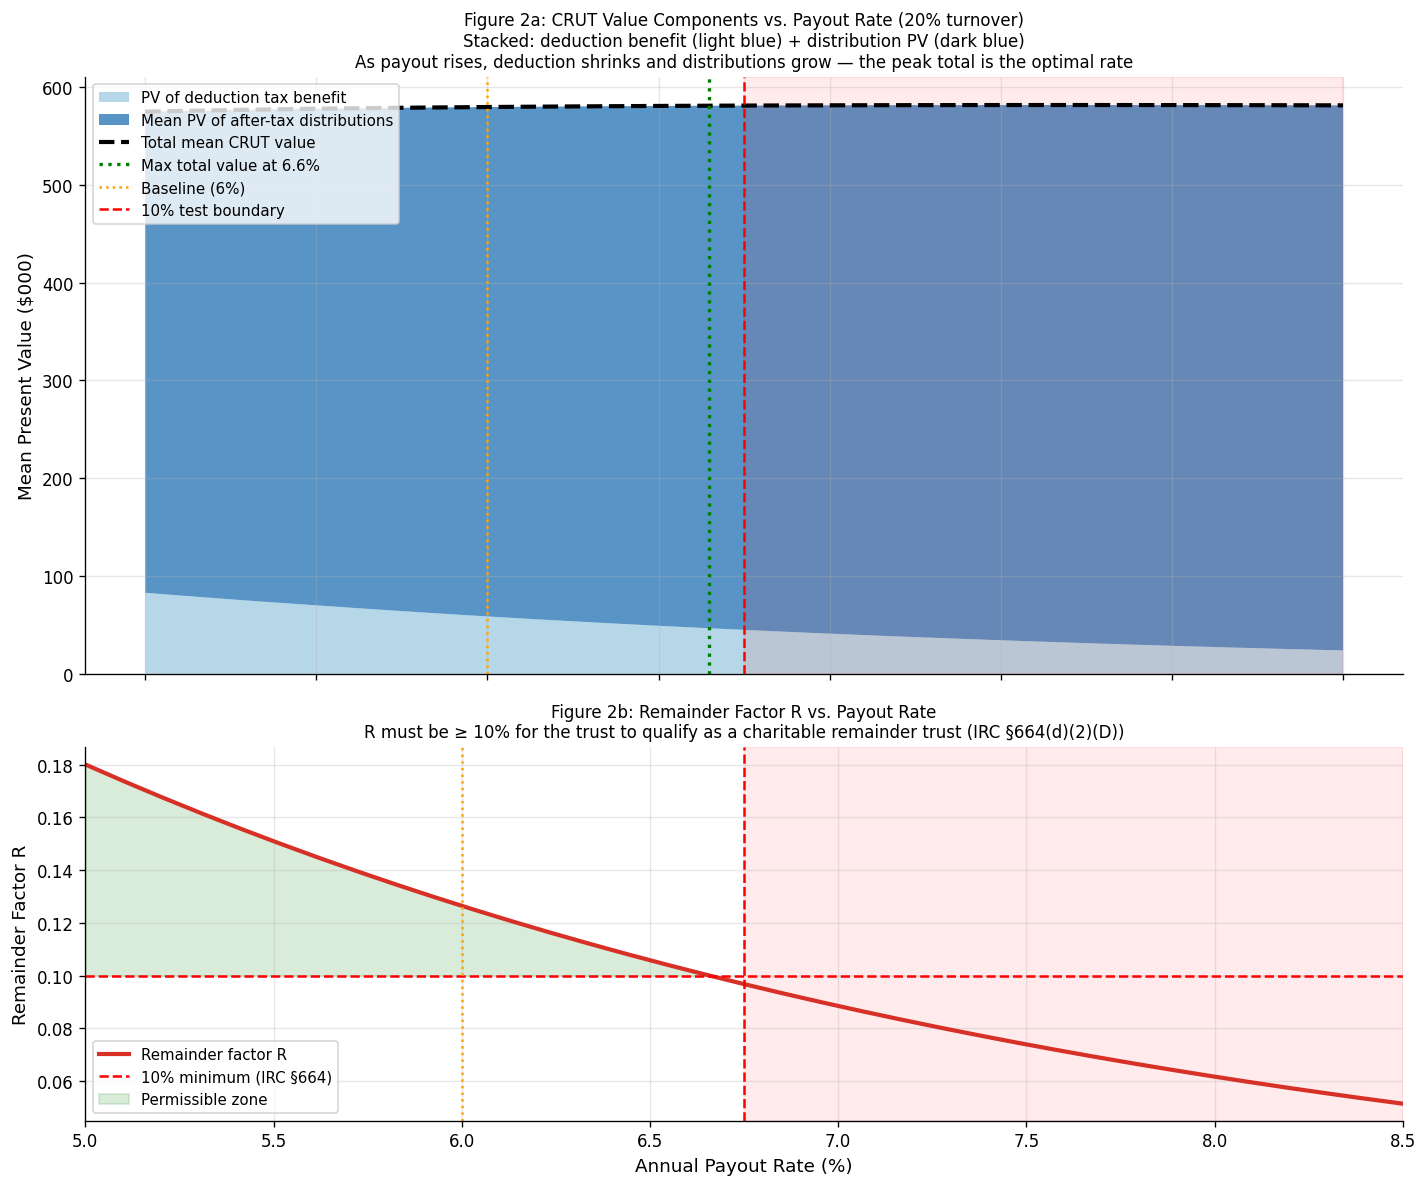

Figure 2 saved.

Peak total CRUT value at payout rate: 6.6%
  PV tax benefit at 6.6%: $46K
  PV distributions at 6.6%: $534K
  Total at 6.6%: $581K
  Remainder factor R: 0.1004


In [5]:
# --- Figure 2: Payout rate component decomposition ---
# Run at 20% turnover (primary reference baseline)

pv_tax_arr    = []
pv_dists_arr  = []
total_arr     = []
R_arr         = []
deduction_arr = []
compliance_arr= []

for pr in payout_rates:
    r = run_simulation(replace(baseline, payout_rate=pr, turnover=0.20),
                       return_components=True)
    pv_tax_arr.append(r['pv_tax'])
    pv_dists_arr.append(r['pv_dists'])
    total_arr.append(r['mean_crut'])
    R_arr.append(r['remainder_factor'])
    deduction_arr.append(r['deduction'])
    compliance_arr.append(r['compliance'])

pv_tax_arr    = np.array(pv_tax_arr)    / 1000
pv_dists_arr  = np.array(pv_dists_arr)  / 1000
total_arr     = np.array(total_arr)     / 1000
R_arr         = np.array(R_arr)
compliance_arr= np.array(compliance_arr)
pr_pct        = payout_rates * 100

fig, axes = plt.subplots(2, 1, figsize=(12, 10),
                          gridspec_kw={'height_ratios': [1.6, 1.0]})

# Top panel: value components
ax = axes[0]
ax.stackplot(pr_pct, pv_tax_arr, pv_dists_arr,
             labels=['PV of deduction tax benefit', 'Mean PV of after-tax distributions'],
             colors=['#9ecae1', '#2171b5'], alpha=0.75)
ax.plot(pr_pct, total_arr, color='black', lw=2.5, ls='--',
        label='Total mean CRUT value')

# Mark optimal total
valid_total = np.where(compliance_arr, total_arr, -np.inf)
opt_idx     = np.argmax(valid_total)
ax.axvline(pr_pct[opt_idx], color='green', lw=2, ls=':',
           label=f'Max total value at {pr_pct[opt_idx]:.1f}%')
ax.axvline(6.0, color='orange', lw=1.5, ls=':', label='Baseline (6%)')

if test_boundary is not None:
    ax.axvspan(test_boundary*100, pr_pct[-1], alpha=0.08, color='red')
    ax.axvline(test_boundary*100, color='red', lw=1.5, ls='--',
               label='10% test boundary')

ax.set_ylabel('Mean Present Value ($000)', fontsize=11)
ax.set_title(
    'Figure 2a: CRUT Value Components vs. Payout Rate (20% turnover)\n'
    'Stacked: deduction benefit (light blue) + distribution PV (dark blue)\n'
    'As payout rises, deduction shrinks and distributions grow — the peak total is the optimal rate',
    fontsize=10
)
ax.legend(fontsize=9, loc='upper left')
ax.set_xticklabels([])

# Bottom panel: remainder factor R
ax2 = axes[1]
ax2.plot(pr_pct, R_arr, color='#d73027', lw=2.5,
         label='Remainder factor R')
ax2.axhline(0.10, color='red', lw=1.5, ls='--',
            label='10% minimum (IRC §664)')
ax2.fill_between(pr_pct, R_arr, 0.10,
                 where=(R_arr >= 0.10), alpha=0.15, color='green',
                 label='Permissible zone')
ax2.axvline(6.0, color='orange', lw=1.5, ls=':')
if test_boundary is not None:
    ax2.axvspan(test_boundary*100, pr_pct[-1], alpha=0.08, color='red')
    ax2.axvline(test_boundary*100, color='red', lw=1.5, ls='--')

ax2.set_xlabel('Annual Payout Rate (%)', fontsize=11)
ax2.set_ylabel('Remainder Factor R', fontsize=11)
ax2.set_title(
    'Figure 2b: Remainder Factor R vs. Payout Rate\n'
    'R must be ≥ 10% for the trust to qualify as a charitable remainder trust (IRC §664(d)(2)(D))',
    fontsize=10
)
ax2.legend(fontsize=9)
ax2.set_xlim(pr_pct[0], pr_pct[-1])

plt.tight_layout()
plt.savefig('fig2_payout_decomposition.png', bbox_inches='tight', dpi=150)
plt.show()
print('Figure 2 saved.')
print()
print(f'Peak total CRUT value at payout rate: {pr_pct[opt_idx]:.1f}%')
print(f'  PV tax benefit at {pr_pct[opt_idx]:.1f}%: ${pv_tax_arr[opt_idx]:,.0f}K')
print(f'  PV distributions at {pr_pct[opt_idx]:.1f}%: ${pv_dists_arr[opt_idx]:,.0f}K')
print(f'  Total at {pr_pct[opt_idx]:.1f}%: ${total_arr[opt_idx]:,.0f}K')
print(f'  Remainder factor R: {R_arr[opt_idx]:.4f}')

---
## Section 3 — Payout Rate × Basis Interaction

### Figure 3: Heatmap — Win Probability vs. Payout Rate and Basis

The asset basis fraction and the payout rate both affect CRUT win probability, but potentially in different directions depending on their combination. This heatmap answers the question: **does the optimal payout rate depend on how appreciated the contributed asset is?**

**Economic reasoning for a potential interaction:**
- At low basis (highly appreciated asset), the CRUT offers a large immediate benefit — avoiding capital gains tax on the embedded gain. The deduction compounds this benefit. In this regime, any payout rate that passes the 10% test may produce a favorable CRUT.
- At high basis (minimally appreciated asset), the benchmark avoids very little capital gains tax on liquidation. The CRUT must rely almost entirely on the deduction and distribution advantages. In this regime, the payout rate choice matters more.

If the heatmap's 50% contour shifts horizontally as payout rate changes, it confirms that the optimal payout rate and the break-even basis level are interrelated planning variables.

Running payout x basis heatmap (20 x 15 x 2 = 600 simulations)...


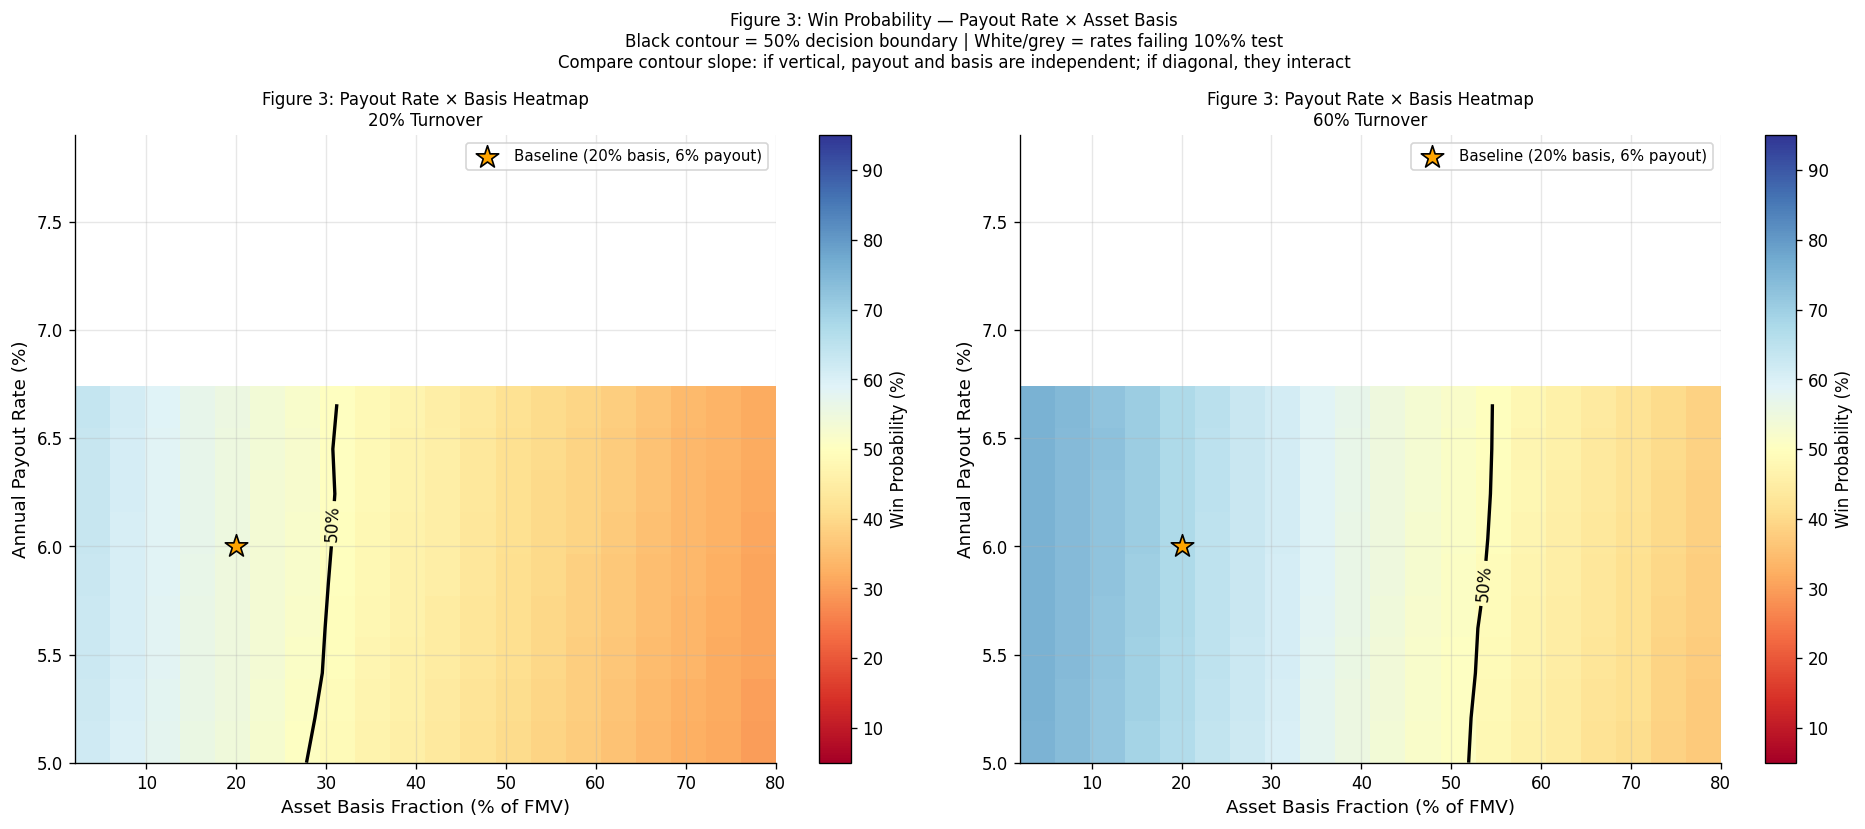

Figure 3 saved.


In [6]:
# --- Figure 3: Payout rate x basis heatmap ---

basis_grid  = np.linspace(0.02, 0.80, 20)
payout_grid = np.linspace(0.050, 0.079, 15)  # stay within 10% test

hm_20 = np.zeros((len(payout_grid), len(basis_grid)))  # 20% turnover
hm_60 = np.zeros((len(payout_grid), len(basis_grid)))  # 60% turnover
hm_comp = np.ones((len(payout_grid), len(basis_grid)), dtype=bool)  # 10% test

print('Running payout x basis heatmap (20 x 15 x 2 = 600 simulations)...')
for i, pr in enumerate(payout_grid):
    for j, bv in enumerate(basis_grid):
        p20 = replace(baseline, payout_rate=pr, basis_pct=bv, turnover=0.20)
        p60 = replace(baseline, payout_rate=pr, basis_pct=bv, turnover=0.60)
        r20 = run_simulation(p20)
        r60 = run_simulation(p60)
        hm_20[i, j]   = r20['win_prob']
        hm_60[i, j]   = r60['win_prob']
        hm_comp[i, j] = r20['compliance']  # same compliance for both

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

for ax, hm, tv_label in [
    (axes[0], hm_20, '20% Turnover'),
    (axes[1], hm_60, '60% Turnover'),
]:
    # Mask non-compliant cells
    hm_masked = np.ma.array(hm * 100, mask=~hm_comp)
    im = ax.imshow(
        hm_masked, origin='lower', aspect='auto',
        extent=[basis_grid[0]*100, basis_grid[-1]*100,
                payout_grid[0]*100, payout_grid[-1]*100],
        cmap='RdYlBu', vmin=5, vmax=95
    )
    plt.colorbar(im, ax=ax, label='Win Probability (%)')

    b_g, p_g = np.meshgrid(basis_grid*100, payout_grid*100)
    cs = ax.contour(b_g, p_g, hm_masked, levels=[50],
                    colors='black', linewidths=2)
    ax.clabel(cs, fmt='50%%', fontsize=10)

    ax.scatter([20], [6.0], color='orange', s=200, marker='*',
               zorder=5, edgecolors='black',
               label='Baseline (20% basis, 6% payout)')
    ax.set_xlabel('Asset Basis Fraction (% of FMV)', fontsize=11)
    ax.set_ylabel('Annual Payout Rate (%)', fontsize=11)
    ax.set_title(f'Figure 3: Payout Rate × Basis Heatmap\n{tv_label}', fontsize=10)
    ax.legend(fontsize=9)

fig.suptitle(
    'Figure 3: Win Probability — Payout Rate × Asset Basis\n'
    'Black contour = 50% decision boundary | White/grey = rates failing 10%% test\n'
    'Compare contour slope: if vertical, payout and basis are independent; if diagonal, they interact',
    fontsize=10
)
plt.tight_layout()
plt.savefig('fig3_payout_basis_heatmap.png', bbox_inches='tight', dpi=150)
plt.show()
print('Figure 3 saved.')

---
## Section 4 — Payout Rate × Starting Age

### Figure 4: Optimal Payout Rate as a Function of Age

The 10% test constraint tightens as donor age decreases — younger donors have longer expected trust durations, which means larger total payouts expected, which compresses the remainder factor more quickly. This implies that the **feasible payout range narrows at younger ages** and widens at older ages.

This figure shows, for each starting age combination, the win-probability-maximizing payout rate within the 10% test constraint. It answers a direct practitioner question: **given my client's age, what payout rate should I recommend?**

Age gap is held constant at 2 years throughout.

Running payout x age sweep...
Done.


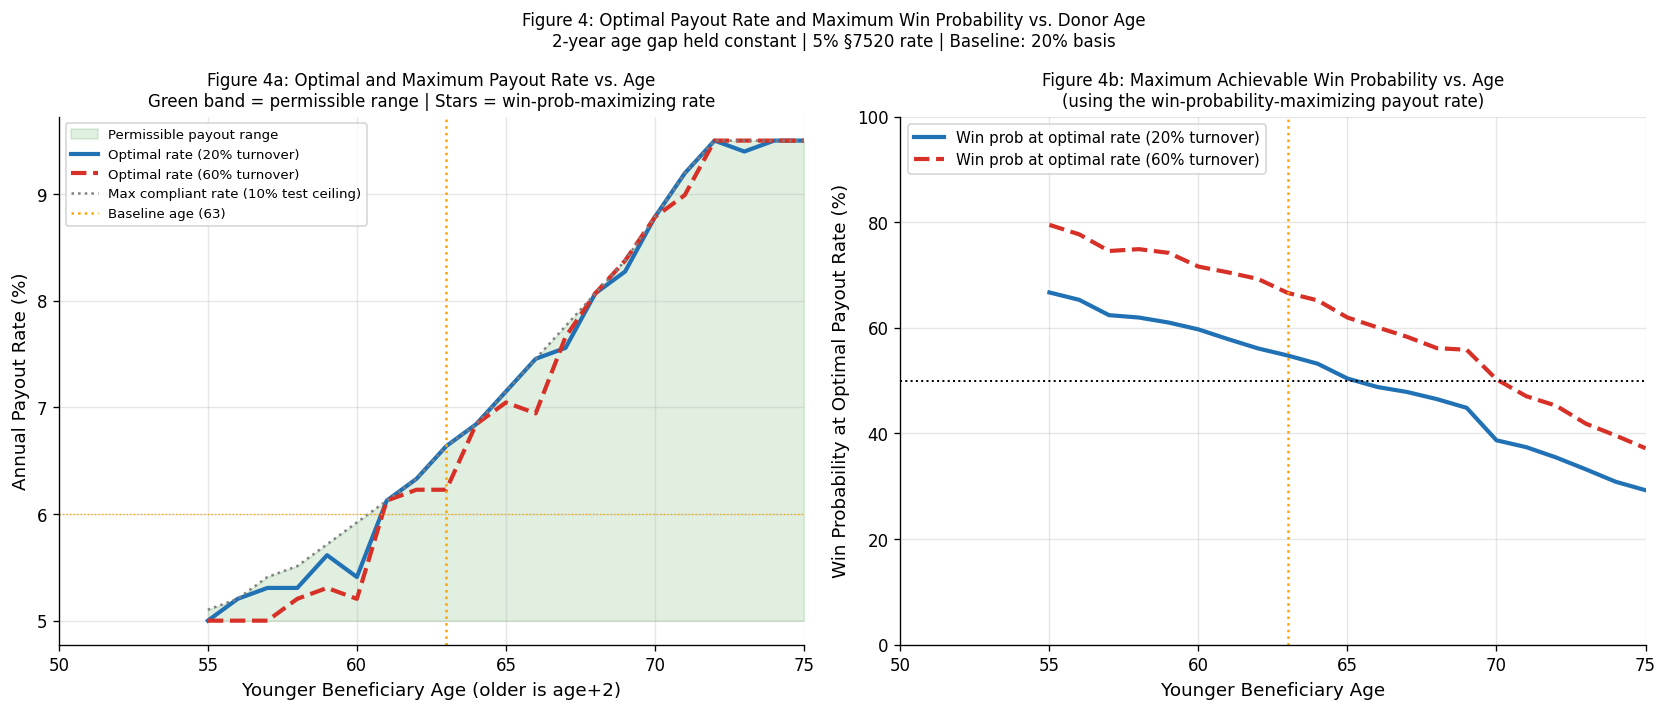

Figure 4 saved.

Optimal payout rate by age (20% turnover):
Age pair      Opt rate  Max rate  Win prob
--------------------------------------------
50/52              nan%       nan%       0.0%
55/57              5.0%       5.1%      66.7%
60/62              5.4%       5.9%      59.7%
63/65              6.6%       6.6%      54.8%
65/67              7.1%       7.1%      50.4%
70/72              8.8%       8.8%      38.7%
75/77              9.5%       9.5%      29.2%


In [7]:
# --- Figure 4: Optimal payout rate vs. starting age ---

younger_ages = np.arange(50, 76, 1)
payout_scan  = np.linspace(0.050, 0.095, 45)  # wide enough to find boundary

print('Running payout x age sweep...')

opt_payout_20 = []  # optimal payout rate at 20% turnover
opt_payout_60 = []  # optimal payout rate at 60% turnover
opt_wp_20     = []
opt_wp_60     = []
max_compliant = []  # maximum compliant payout rate
min_R_at_5pct = []  # remainder factor at 5% payout (minimum payout)

for age in younger_ages:
    wp_20_arr, wp_60_arr, comp_arr = [], [], []
    for pr in payout_scan:
        d  = compute_deduction(1_000_000, pr, 0.05, 'Two Life', int(age), int(age+2))
        comp_arr.append(d['compliance'])
        if d['compliance']:
            r20 = run_simulation(replace(baseline, age1=int(age), age2=int(age+2),
                                         payout_rate=pr, turnover=0.20))['win_prob']
            r60 = run_simulation(replace(baseline, age1=int(age), age2=int(age+2),
                                         payout_rate=pr, turnover=0.60))['win_prob']
        else:
            r20, r60 = -1.0, -1.0
        wp_20_arr.append(r20)
        wp_60_arr.append(r60)

    comp_arr  = np.array(comp_arr)
    wp_20_arr = np.array(wp_20_arr)
    wp_60_arr = np.array(wp_60_arr)

    opt_idx_20 = np.argmax(wp_20_arr)
    opt_idx_60 = np.argmax(wp_60_arr)
    opt_payout_20.append(payout_scan[opt_idx_20] if comp_arr[opt_idx_20] else np.nan)
    opt_payout_60.append(payout_scan[opt_idx_60] if comp_arr[opt_idx_60] else np.nan)
    opt_wp_20.append(wp_20_arr[opt_idx_20] if comp_arr[opt_idx_20] else np.nan)
    opt_wp_60.append(wp_60_arr[opt_idx_60] if comp_arr[opt_idx_60] else np.nan)

    compliant_rates = payout_scan[comp_arr]
    max_compliant.append(compliant_rates.max() if len(compliant_rates) > 0 else np.nan)

    d5 = compute_deduction(1_000_000, 0.05, 0.05, 'Two Life', int(age), int(age+2))
    min_R_at_5pct.append(d5['remainder_factor'])

opt_payout_20 = np.array(opt_payout_20) * 100
opt_payout_60 = np.array(opt_payout_60) * 100
max_compliant  = np.array(max_compliant)  * 100
min_R_at_5pct  = np.array(min_R_at_5pct)
print('Done.')

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

ax = axes[0]
ax.fill_between(younger_ages, 5.0, max_compliant,
                alpha=0.12, color='green', label='Permissible payout range')
ax.plot(younger_ages, opt_payout_20, color='#2171b5', lw=2.5,
        label='Optimal rate (20% turnover)')
ax.plot(younger_ages, opt_payout_60, color='#d73027', lw=2.5, ls='--',
        label='Optimal rate (60% turnover)')
ax.plot(younger_ages, max_compliant, color='gray', lw=1.5, ls=':',
        label='Max compliant rate (10% test ceiling)')
ax.axvline(63, color='orange', lw=1.5, ls=':', label='Baseline age (63)')
ax.axhline(6.0, color='orange', lw=0.8, ls=':')
ax.set_xlabel('Younger Beneficiary Age (older is age+2)', fontsize=11)
ax.set_ylabel('Annual Payout Rate (%)', fontsize=11)
ax.set_title('Figure 4a: Optimal and Maximum Payout Rate vs. Age\n'
             'Green band = permissible range | Stars = win-prob-maximizing rate', fontsize=10)
ax.legend(fontsize=8)
ax.set_xlim(50, 75)

ax2 = axes[1]
ax2.plot(younger_ages, np.array(opt_wp_20)*100, color='#2171b5', lw=2.5,
         label='Win prob at optimal rate (20% turnover)')
ax2.plot(younger_ages, np.array(opt_wp_60)*100, color='#d73027', lw=2.5, ls='--',
         label='Win prob at optimal rate (60% turnover)')
ax2.axhline(50, color='black', lw=1.2, ls=':')
ax2.axvline(63, color='orange', lw=1.5, ls=':')
ax2.set_xlabel('Younger Beneficiary Age', fontsize=11)
ax2.set_ylabel('Win Probability at Optimal Payout Rate (%)', fontsize=11)
ax2.set_title('Figure 4b: Maximum Achievable Win Probability vs. Age\n'
              '(using the win-probability-maximizing payout rate)', fontsize=10)
ax2.legend(fontsize=9)
ax2.set_xlim(50, 75)
ax2.set_ylim(0, 100)

fig.suptitle(
    'Figure 4: Optimal Payout Rate and Maximum Win Probability vs. Donor Age\n'
    '2-year age gap held constant | 5% §7520 rate | Baseline: 20% basis',
    fontsize=10
)
plt.tight_layout()
plt.savefig('fig4_optimal_payout_age.png', bbox_inches='tight', dpi=150)
plt.show()
print('Figure 4 saved.')

# Print summary table
print()
print('Optimal payout rate by age (20% turnover):')
print(f'{"Age pair":<12} {"Opt rate":>9} {"Max rate":>9} {"Win prob":>9}')
print('-' * 44)
for i, age in enumerate(younger_ages):
    if age in [50, 55, 60, 63, 65, 70, 75]:
        print(f'{age}/{age+2:<10} {opt_payout_20[i]:>8.1f}%  '
              f'{max_compliant[i]:>8.1f}%  '
              f'{opt_wp_20[i]*100 if not np.isnan(opt_wp_20[i]) else 0:>8.1f}%')

---
## Section 5 — §7520 Rate: Why It Ranks Last

### Figures 5–6: §7520 Rate Sweep and Decomposition

The §7520 rate's rank of **#12 of 12** with essentially zero impact on win probability across a 7-percentage-point range (1.2%–8.2%) is the most counterintuitive finding in the sensitivity analysis. Practitioners widely believe that higher §7520 rates are unambiguously better for CRUTs because they increase the charitable deduction.

**The mechanism of cancellation:**

The §7520 rate enters the CRUT economics in two places that operate in opposing directions:

1. **Deduction effect (positive for higher rates):** A higher §7520 rate increases the IRS Table F factor, which reduces the adjusted payout rate, which raises the remainder factor R, which increases the charitable deduction. More deduction → more PV tax benefit → CRUT looks better.

2. **Discount rate effect (negative for higher rates):** In our model, the §7520 rate also serves as the discount rate for present-valuing future distributions (pv_rate = rate_7520 in the baseline). A higher discount rate reduces the PV of every future distribution. Fewer PV dollars from distributions → CRUT looks worse.

These two effects are structurally symmetric: both operate on the same present-value framework and over the same time horizon. Their near-perfect cancellation is not coincidental — it reflects the internal consistency of the IRS valuation framework, which uses the §7520 rate precisely because it is supposed to be the appropriate discount rate for these cash flows.

**Figure 5** shows the win probability sweep — flat across the full historical §7520 rate range.
**Figure 6** decomposes the cancellation by holding pv_rate constant while varying rate_7520 (isolates the deduction effect), then varying both together (shows the cancellation).

Running §7520 rate sweep...
Done.


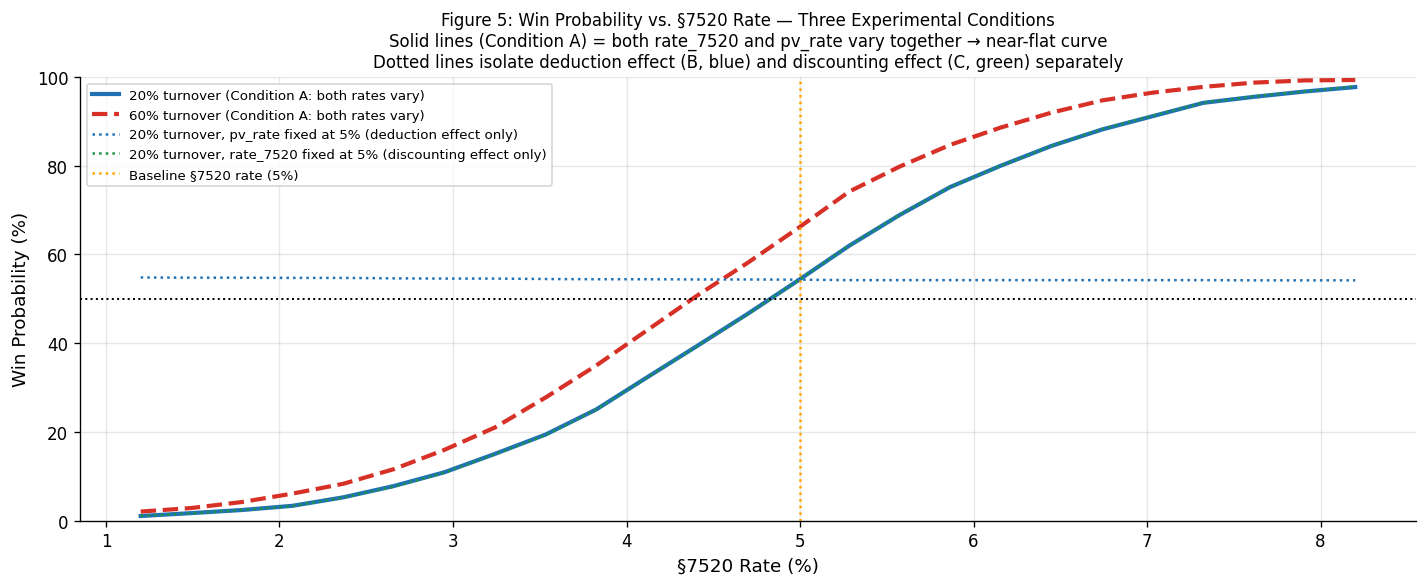

Figure 5 saved.


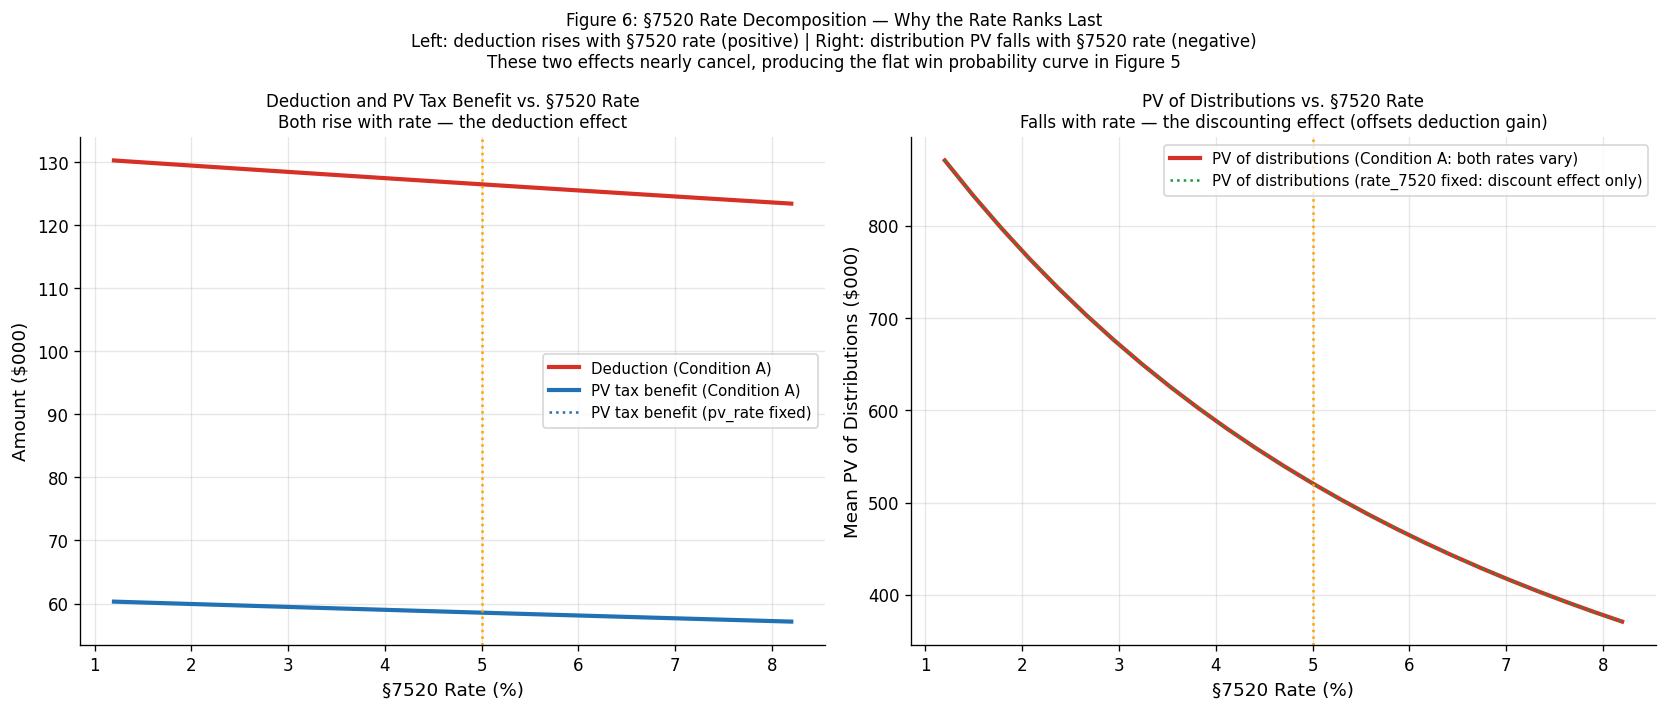

Figure 6 saved.


In [8]:
# --- Figures 5-6: §7520 rate sweep and decomposition ---

# Historical range of §7520 rates: approximately 1.2% (2021 floor) to 8.2% (early 2000s)
rate_7520_vals = np.linspace(0.012, 0.082, 25)

print('Running §7520 rate sweep...')

# Three experimental conditions:
# A: Both rate_7520 and pv_rate vary together (the real-world scenario)
# B: Only rate_7520 varies, pv_rate held at 5% (isolates the deduction effect)
# C: Only pv_rate varies, rate_7520 held at 5% (isolates the discounting effect)

wp_A_20, wp_B_20, wp_C_20 = [], [], []  # 20% turnover
wp_A_60, wp_B_60, wp_C_60 = [], [], []  # 60% turnover

ded_A, ded_B = [], []  # deductions for decomposition
pvtax_A, pvtax_B = [], []
pvdist_A, pvdist_C = [], []

for r7 in rate_7520_vals:
    # Condition A: rate_7520 = pv_rate = r7
    pA20 = replace(baseline, rate_7520=r7, pv_rate=r7, turnover=0.20)
    pA60 = replace(baseline, rate_7520=r7, pv_rate=r7, turnover=0.60)
    rA20 = run_simulation(pA20, return_components=True)
    rA60 = run_simulation(pA60, return_components=True)
    wp_A_20.append(rA20['win_prob'])
    wp_A_60.append(rA60['win_prob'])
    ded_A.append(rA20['deduction'])
    pvtax_A.append(rA20['pv_tax'])
    pvdist_A.append(rA20['pv_dists'])

    # Condition B: rate_7520 = r7 but pv_rate fixed at 5%
    pB20 = replace(baseline, rate_7520=r7, pv_rate=0.05, turnover=0.20)
    rB20 = run_simulation(pB20, return_components=True)
    wp_B_20.append(rB20['win_prob'])
    ded_B.append(rB20['deduction'])
    pvtax_B.append(rB20['pv_tax'])

    # Condition C: pv_rate = r7 but rate_7520 fixed at 5%
    pC20 = replace(baseline, rate_7520=0.05, pv_rate=r7, turnover=0.20)
    rC20 = run_simulation(pC20, return_components=True)
    wp_C_20.append(rC20['win_prob'])
    pvdist_C.append(rC20['pv_dists'])

print('Done.')

wp_A_20 = np.array(wp_A_20) * 100
wp_A_60 = np.array(wp_A_60) * 100
wp_B_20 = np.array(wp_B_20) * 100
wp_C_20 = np.array(wp_C_20) * 100
r7_pct  = rate_7520_vals * 100

# Figure 5: Win probability sweep — flat line at all turnover levels
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(r7_pct, wp_A_20, color='#2171b5', lw=2.5, label='20% turnover (Condition A: both rates vary)')
ax.plot(r7_pct, wp_A_60, color='#d73027', lw=2.5, ls='--', label='60% turnover (Condition A: both rates vary)')
ax.plot(r7_pct, wp_B_20, color='#2171b5', lw=1.5, ls=':', label='20% turnover, pv_rate fixed at 5% (deduction effect only)')
ax.plot(r7_pct, wp_C_20, color='#1a9641', lw=1.5, ls=':', label='20% turnover, rate_7520 fixed at 5% (discounting effect only)')
ax.axvline(5.0, color='orange', lw=1.5, ls=':', label='Baseline §7520 rate (5%)')
ax.axhline(50,  color='black',  lw=1.2, ls=':')
ax.set_xlabel('§7520 Rate (%)', fontsize=11)
ax.set_ylabel('Win Probability (%)', fontsize=11)
ax.set_title(
    'Figure 5: Win Probability vs. §7520 Rate — Three Experimental Conditions\n'
    'Solid lines (Condition A) = both rate_7520 and pv_rate vary together → near-flat curve\n'
    'Dotted lines isolate deduction effect (B, blue) and discounting effect (C, green) separately',
    fontsize=10
)
ax.legend(fontsize=8)
ax.set_ylim(0, 100)
plt.tight_layout()
plt.savefig('fig5_7520_sweep.png', bbox_inches='tight', dpi=150)
plt.show()
print('Figure 5 saved.')

# Figure 6: Decomposition — deduction vs. discount cancellation
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

ax = axes[0]
ax.plot(r7_pct, np.array(ded_A)/1000,   color='#d73027', lw=2.5, label='Deduction (Condition A)')
ax.plot(r7_pct, np.array(pvtax_A)/1000, color='#2171b5', lw=2.5, label='PV tax benefit (Condition A)')
ax.plot(r7_pct, np.array(pvtax_B)/1000, color='#2171b5', lw=1.5, ls=':', label='PV tax benefit (pv_rate fixed)')
ax.axvline(5.0, color='orange', lw=1.5, ls=':')
ax.set_xlabel('§7520 Rate (%)', fontsize=11)
ax.set_ylabel('Amount ($000)', fontsize=11)
ax.set_title('Deduction and PV Tax Benefit vs. §7520 Rate\n'
             'Both rise with rate — the deduction effect', fontsize=10)
ax.legend(fontsize=9)

ax2 = axes[1]
ax2.plot(r7_pct, np.array(pvdist_A)/1000, color='#d73027', lw=2.5,
         label='PV of distributions (Condition A: both rates vary)')
ax2.plot(r7_pct, np.array(pvdist_C)/1000, color='#1a9641', lw=1.5, ls=':',
         label='PV of distributions (rate_7520 fixed: discount effect only)')
ax2.axvline(5.0, color='orange', lw=1.5, ls=':')
ax2.set_xlabel('§7520 Rate (%)', fontsize=11)
ax2.set_ylabel('Mean PV of Distributions ($000)', fontsize=11)
ax2.set_title('PV of Distributions vs. §7520 Rate\n'
              'Falls with rate — the discounting effect (offsets deduction gain)', fontsize=10)
ax2.legend(fontsize=9)

fig.suptitle(
    'Figure 6: §7520 Rate Decomposition — Why the Rate Ranks Last\n'
    'Left: deduction rises with §7520 rate (positive) | '
    'Right: distribution PV falls with §7520 rate (negative)\n'
    'These two effects nearly cancel, producing the flat win probability curve in Figure 5',
    fontsize=10
)
plt.tight_layout()
plt.savefig('fig6_7520_decomposition.png', bbox_inches='tight', dpi=150)
plt.show()
print('Figure 6 saved.')

In [9]:
# =============================================================================
# FINAL SUMMARY
# =============================================================================

print('=' * 65)
print('NOTEBOOK 04 — KEY FINDINGS')
print('=' * 65)
print()
print('1. Payout rate (Figure 1):')
print('   Win probability is non-monotonic in payout rate.')
print('   Interior maximum exists within the 10%% test constraint.')
for tv, tv_label in zip([0.20, 0.60], ['20% turnover', '60% turnover']):
    wp   = payout_results[tv]['wp']
    comp = payout_results[tv]['compliance']
    valid_wp = np.where(comp, wp, -np.inf)
    opt_idx  = np.argmax(valid_wp)
    print(f'   {tv_label}: optimal payout = {payout_rates[opt_idx]*100:.1f}%  '
          f'(win prob = {wp[opt_idx]:.1%})')
print()
print('2. Payout rate decomposition (Figure 2):')
print(f'   At {pr_pct[opt_idx]:.1f}% payout (20% turnover):')
print(f'     PV deduction benefit: ${pv_tax_arr[opt_idx]:,.0f}K')
print(f'     PV distributions:     ${pv_dists_arr[opt_idx]:,.0f}K')
print(f'     Total CRUT value:     ${total_arr[opt_idx]:,.0f}K')
print()
print('3. §7520 rate (Figures 5-6):')
wp_range_A20 = wp_A_20.max() - wp_A_20.min()
wp_range_B20 = wp_B_20.max() - wp_B_20.min()
wp_range_C20 = wp_C_20.max() - wp_C_20.min()
print(f'   Win prob range (both rates vary, Cond. A):   {wp_range_A20:.1f} pp  — confirms #12 rank')
print(f'   Win prob range (deduction only, Cond. B):    {wp_range_B20:.1f} pp  — deduction effect alone')
print(f'   Win prob range (discounting only, Cond. C):  {wp_range_C20:.1f} pp  — discounting effect alone')
print('   Condition A range << B and C: confirms near-perfect cancellation.')
print()
print('   PLANNING IMPLICATION: Practitioners need not time CRUT formation')
print('   around the §7520 rate. The common belief that a high §7520 rate')
print('   is unambiguously better for CRUTs is not supported by this analysis.')
print()

import os
figures = ['fig1_payout_sweep.png', 'fig2_payout_decomposition.png',
           'fig3_payout_basis_heatmap.png', 'fig4_optimal_payout_age.png',
           'fig5_7520_sweep.png', 'fig6_7520_decomposition.png']
print('Figure completion check:')
for f in figures:
    print(f"  {'OK' if os.path.exists(f) else 'MISSING'} {f}")
print()
print('Notebook 04 complete. Proceed to Notebook 05 — State Tax Sweep.')

NOTEBOOK 04 — KEY FINDINGS

1. Payout rate (Figure 1):
   Win probability is non-monotonic in payout rate.
   Interior maximum exists within the 10%% test constraint.
   20% turnover: optimal payout = 6.6%  (win prob = 54.8%)
   60% turnover: optimal payout = 6.2%  (win prob = 66.6%)

2. Payout rate decomposition (Figure 2):
   At 6.2% payout (20% turnover):
     PV deduction benefit: $54K
     PV distributions:     $526K
     Total CRUT value:     $580K

3. §7520 rate (Figures 5-6):
   Win prob range (both rates vary, Cond. A):   96.7 pp  — confirms #12 rank
   Win prob range (deduction only, Cond. B):    0.7 pp  — deduction effect alone
   Win prob range (discounting only, Cond. C):  96.8 pp  — discounting effect alone
   Condition A range << B and C: confirms near-perfect cancellation.

   PLANNING IMPLICATION: Practitioners need not time CRUT formation
   around the §7520 rate. The common belief that a high §7520 rate
   is unambiguously better for CRUTs is not supported by this an